# HW2P2: Face Classification and Verification


This is the second homework in 11785: Introduction to Deep Learning consisting of two parts:
*   Face Recognition: You will be writing your own CNN model to tackle the problem of classification, consisting of 7001 identities.
*   Face Verification: You use the model trained for classification to evaluate the quality of its feature embeddings, by comparing the similarity of known and unknown identities.

For this HW, you only have to write code to implement your model architecture. Everything else has been provided for you, on the pretext that most of your time will be used up in developing the suitable model architecture for achieving satisfactory performance.

Common errors which you may face in this homeworks (because of the size of the model)


*   CUDA Out of Memory (OOM): You can tackle this problem by (1) Reducing the batch size (2) Calling `torch.cuda.empty_cache()` and `gc.collect()` (3) Finally restarting the runtime



# TODOs
As you go, please read the code and keep an eye out for TODOs.

**Structure of this notebook**:

1. **Libraries** - just run it
2. **Kaggle** - copy the code from HW1P2 and add a correct API key
3. **Configs** - specify your configs
4. **Dataset**
  - **Datasets and Dataloaders** - it's already implemented, just specify your preferred augmentations/transformations
  - **EDA and Viz** - just run it to check if your augmentations/transformations worked
5. **Model Architecture** - implement and define your preferred model architecture
6. **Loss, Optimizer, and Scheduler** - define your loss, optimizer, and a scheduler
7. **Training and Validation Functions** - includes functions for both classification and verification tasks
  - **Classification Task** - just run it
  - **Verification Task** - just run it
8. **Wandb** - add a correct API key
9. **Experiments** - make changes if needed; it will show you train/val/test accuracy for both classification and verification. **Important**: make sure you save your best model checkpoints because models in this HW take a long time to get trained
10. **Testing and Kaggle Submission** - just run it
11. **Model Finetuning** - this part might help you get a higher score on the verification part
  - **Model Implementations (CenterLoss, ArcFace, or SphereFace)** - please refer to the additional notebook and just copy the model from there
  - **Model Definition (finetuning)** - you may reuse the code from the main part
  - **Loss, Optimizer, and Scheduler Definition (finetuning)** - you may reuse the code from the main part
  - **Training Function (finetuning)** - you may reuse the code from the main part
  - **Wandb (finetuning)** - you may reuse the code from the main part
  - **Experiments (finetuning)** - you may reuse the code from the main part

Good luck!

# Libraries

In [ ]:
!nvidia-smi # Run this to see what GPU you have

Wed Mar 13 18:54:37 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0              23W / 300W |      0MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

#NOTE: RESTART THE RUN TIME AFTER RUNNING THE THE CELL BELOW

In [ ]:
# Install the necessary packages. Very important: Please restart your session in Colab/Local Machine
# You can restart your session in colab by going to Runtime and then clicking restart session
!pip install wandb --quiet
!pip install torch==1.12.1 torchvision==0.13.1 torchaudio==0.12.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.8/258.8 kB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.3/776.3 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 68.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 93.6 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.1.0+cu121
    Uninstalling torch-2.1.0+cu121:
      Successfully uninstalled torch-2.1.0+cu121
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.16.0+cu121
    Uninstalling torchvision-0.16.0+cu121:
      Successfully uninstalled torchvision-0.16.0+cu121
  Attempting uninstall: torchaudio
    Found existing installation: torcha

In [ ]:
# Import the important packages for this Homework. Feel free to add anything here you need.
import torch
from torchsummary import summary
import torchvision # This library is used for image-based operations (Augmentations)
import os
import gc
from tqdm import tqdm
from PIL import Image
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
import glob
import wandb
import matplotlib.pyplot as plt
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", DEVICE)


Device:  cuda


In [ ]:
from google.colab import drive # Link to your drive if you are not using Colab with GCP
drive.mount('/content/drive') # Models in this HW take a long time to get trained and make sure to save it here

Mounted at /content/drive


# Kaggle

In [ ]:
# TODO: Use the same Kaggle code from HW1P2

In [ ]:
# Reminder: Make sure you have connected your kaggle API before running this block
!mkdir '/content/data'
!mkdir -p '/root/.kaggle'

with open("/root/.kaggle/kaggle.json", "w+") as f:
    f.write('{"username":"alectrela","key":"42d0f6df23d52bb3b9e5a7b2cb5e1962"}')

!kaggle competitions download -c 11785-hw2p2-face-recognition
!unzip -qo '11785-hw2p2-face-recognition.zip' -d '/content/data'

!kaggle competitions download -c 11785-hw2p2-face-verification
!unzip -qo '11785-hw2p2-face-verification.zip' -d '/content/data'

100% 1.71G/1.71G [00:46<00:00, 44.2MB/s]
100% 1.71G/1.71G [00:46<00:00, 39.9MB/s]
100% 16.8M/16.8M [00:00<00:00, 27.8MB/s]
100% 16.8M/16.8M [00:00<00:00, 17.7MB/s]


# Configs

In [ ]:
channels = []
channels += [256 for _ in range(1)]
channels += [512 for _ in range(1)]
channels += [1024 for _ in range(1)]

config = {
    'batch_size': 128, # Increase this if your GPU can handle it
    'lr': 0.02,
    'epochs': 100, # 20 epochs is recommended ONLY for the early submission - you will have to train for much longer typically.
    # Include other parameters as needed.,
    'warmstart': 15,
    'label-smoothing': 0.1,
    'model': 'resnet-bottleneck-check',
    'block-channels': channels,
    "bottleneck-reduction": 4,
    'notes': 'deep ResNet bottleneck',
    'transforms': "RandomRotation(degrees=45), RandomHorizontalFlip(p=0.5), Normalize(mean=train_mean, std=train_std)"
}

# Dataset

## Datasets and Dataloaders

In [ ]:
# --------------------------------------------------- #

# Data paths

DATA_DIR    = "/content/data/11-785-s24-hw2p2-classification/" # TODO: Path where you have downloaded the classificaation data
TRAIN_DIR   = os.path.join(DATA_DIR, "train")
VAL_DIR     = os.path.join(DATA_DIR, "dev")
TEST_DIR    = os.path.join(DATA_DIR, "test")

# --------------------------------------------------- #

# Transformations/augmentations of the Train dataset

"""
Refer https://pytorch.org/vision/stable/transforms.html
Implementing the right train transforms/augmentation methods is key to improving performance.
Most torchvision transforms are done on PIL images. So you convert it into a tensor at the end with ToTensor()
But there are some transforms which are performed after ToTensor() : e.g - Normalization
#Normalization Tip - Do not blindly use normalization that is not suitable for this dataset
"""

train_mean = [0.5102, 0.4014, 0.3508]
train_std  = [0.3075, 0.2701, 0.2591]

train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.RandomRotation(degrees=45), # +/- 45 degrees here
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=train_mean, std=train_std)
    ]) # TODO: Specify transformations/augmentations performed on the train dataset

# --------------------------------------------------- #

# Transformations/augmentations of the Val dataset

"""
You should NOT have data augmentation on the validation set. Why?
"""

valid_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=train_mean, std=train_std)
    ]) # TODO: Specify transformations performed on the val dataset

# --------------------------------------------------- #

# Initializing the train and val datasets

train_dataset   = torchvision.datasets.ImageFolder(TRAIN_DIR, transform = train_transforms)
valid_dataset   = torchvision.datasets.ImageFolder(VAL_DIR, transform = valid_transforms)

# --------------------------------------------------- #

# Initializing the train and val dataloaders

train_loader = torch.utils.data.DataLoader(dataset       = train_dataset,
                                           batch_size    = config['batch_size'],
                                           shuffle        = True,
                                           num_workers = 4, # Uncomment this line if you want to increase your num workers
                                           pin_memory    = True)

valid_loader = torch.utils.data.DataLoader(dataset       = valid_dataset,
                                           batch_size    = config['batch_size'],
                                           shuffle        = False,
                                           num_workers = 2 # Uncomment this line if you want to increase your num workers
                                           )

In [ ]:
# --------------------------------------------------- #

# Test dataset class

"""
You can do this with ImageFolder as well, but it requires some tweaking
"""

class TestDataset(torch.utils.data.Dataset):

    def __init__(self, data_dir, transforms):
        self.data_dir   = data_dir
        self.transforms = transforms

        # This one-liner basically generates a sorted list of full paths to each image in the test directory
        self.img_paths  = list(map(lambda fname: os.path.join(self.data_dir, fname), sorted(os.listdir(self.data_dir))))

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        return self.transforms(Image.open(self.img_paths[idx]))

# --------------------------------------------------- #

# Initializing the test dataset

"""
Why are we using val_transforms for Test Data?
"""

test_dataset = TestDataset(TEST_DIR, transforms = valid_transforms)

# --------------------------------------------------- #

# Initializing the test dataloader

test_loader = torch.utils.data.DataLoader(dataset    = test_dataset,
                                          batch_size = config['batch_size'],
                                          shuffle     = False,
                                          drop_last  = False,
                                          num_workers = 2 # Uncomment this line if you want to increase your num workers
                                          )

## Computing the Mean & STD of the Data


---


**Notes:**
* Until proven otherwise, I will use the mean/std of each set independently. Explicitly, train_loader, valid_loader, test_loader will all be normalized based on their values.
* See [this link](https://kozodoi.me/python/deep%20learning/pytorch/tutorial/2021/03/08/image-mean-std.html) for the full explanation.
* Essentially we need to sum over dimension 1 assumption (batch_size, channels, rows, cols). The rest is self explanatory
* Normalizations should be added before transformations based on the TA recommendations. Which makes sense as augmentations are random so we cannot compute mean, std ahead of time.

---


**Train Loader:**
 * mean: tensor([0.5102, 0.4014, 0.3508])
 * std:  tensor([0.3075, 0.2701, 0.2591])



In [ ]:
# from tqdm import tqdm

# for data in train_loader:
#     single_item_shape = data[0].shape
#     print("Single Item Stats:")
#     print(data[0].mean(axis = [0, 2, 3]))
#     print(data[0].std(axis = [0, 2, 3]))
#     break

# # placeholders
# psum    = torch.tensor([0.0, 0.0, 0.0])
# psum_sq = torch.tensor([0.0, 0.0, 0.0])

# for data in tqdm(train_loader):

#   # loop through images
#   # for inputs in tqdm(data):
#   psum    += data[0].sum(axis        = [0, 2, 3])
#   psum_sq += (data[0] ** 2).sum(axis = [0, 2, 3])

# # pixel count
# count = len(train_loader) * single_item_shape[0] * single_item_shape[2] * single_item_shape[3]

# # mean and std
# total_mean = psum / count

# total_var  = (psum_sq / count) - (total_mean ** 2)
# total_std  = torch.sqrt(total_var)

# # output
# print('\n mean: '  + str(total_mean))
# print(' std:  '  + str(total_std))

## EDA and Viz

In [ ]:
# Double-check your dataset/dataloaders work as expected

print("Number of classes    : ", len(train_dataset.classes))
print("No. of train images  : ", train_dataset.__len__())
print("Shape of image       : ", train_dataset[0][0].shape)
print("Batch size           : ", config['batch_size'])
print("Train batches        : ", train_loader.__len__())
print("Val batches          : ", valid_loader.__len__())

# Feel free to print more things if needed

Number of classes    :  7001
No. of train images  :  140020
Shape of image       :  torch.Size([3, 224, 224])
Batch size           :  128
Train batches        :  1094
Val batches          :  274


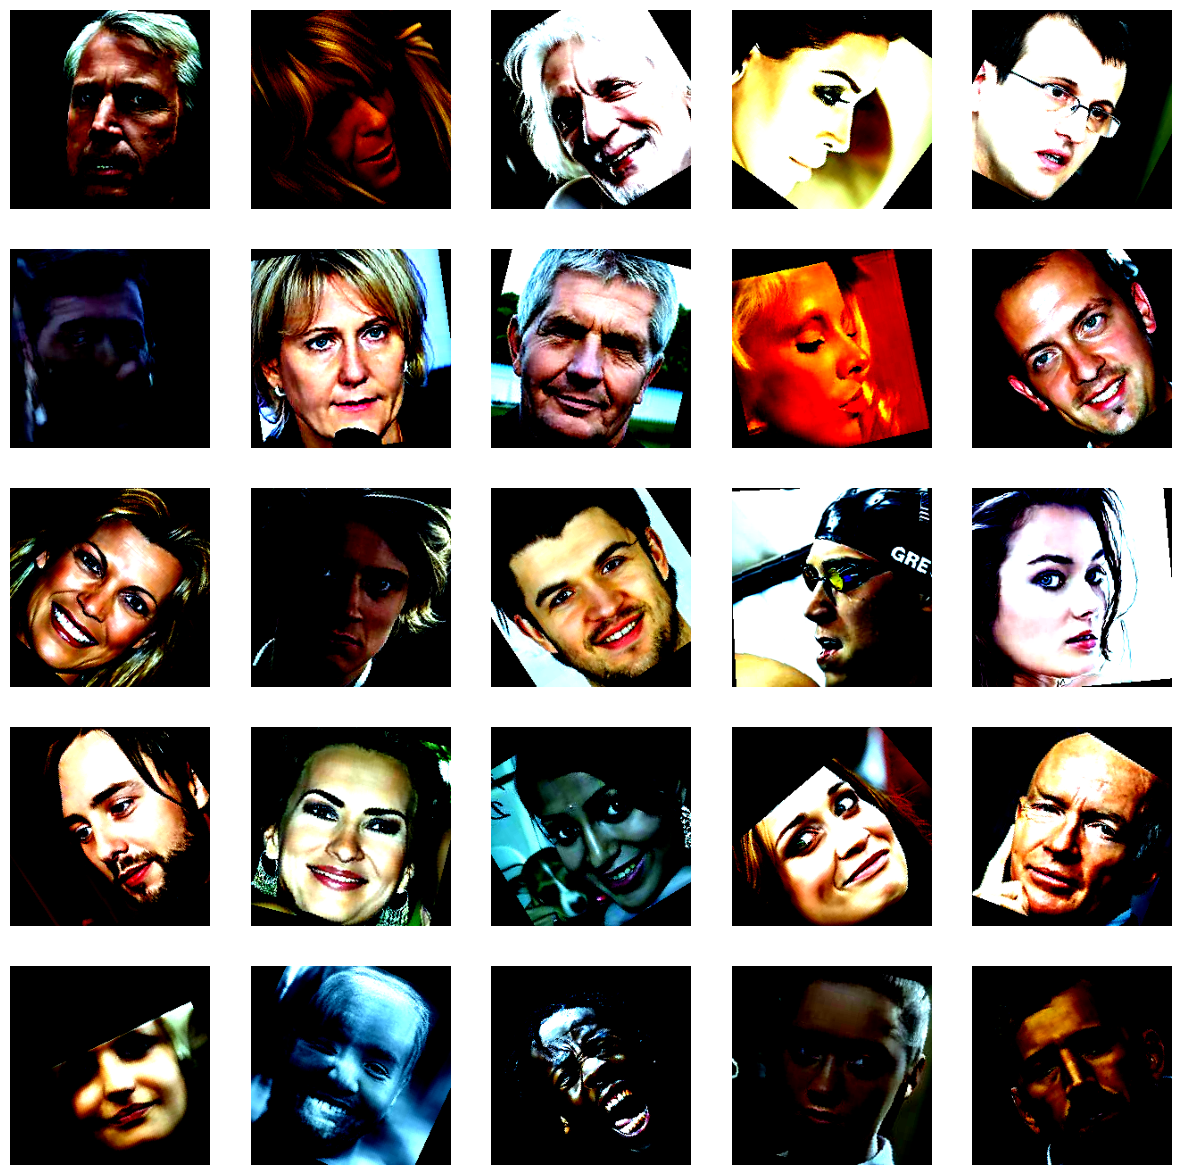

In [ ]:
# Visualize a few images in the dataset

"""
You can write your own code, and you don't need to understand the code
It is highly recommended that you visualize your data augmentation as sanity check
"""

r, c    = [5, 5]
fig, ax = plt.subplots(r, c, figsize= (15, 15))

k       = 0
dtl     = torch.utils.data.DataLoader(
    dataset     = torchvision.datasets.ImageFolder(TRAIN_DIR, transform= train_transforms), # dont wanna see the images with transforms
    batch_size  = config['batch_size'],
    shuffle     = True)

for data in dtl:
    x, y = data

    for i in range(r):
        for j in range(c):
            img = x[k].numpy().transpose(1, 2, 0)
            ax[i, j].imshow(img)
            ax[i, j].axis('off')
            k+=1
    break

del dtl

# Model Architecture

FAQ:

**What's a very low early deadline architecture (mandatory early submission)**?

- The very low early deadline architecture is a 5-layer CNN. Keep in mind the parameter limit is 18M.
- The first convolutional layer has 64 channels, kernel size 7, and stride 4. The next four have 128, 256, 512 and 1024 channels. Each have kernel size 3 and stride 2. Documentation to make convolutional layers: https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
- Think about strided convolutions from the lecture, as convolutions with stride = 1 and downsampling. For strided convolution, what padding do you need for preserving the spatial resolution? (Hint => padding = kernel_size // 2) - Think why?
- Each convolutional layer is accompanied by a Batchnorm and ReLU layer.
- Finally, you want to average pool over the spatial dimensions to reduce them to 1 x 1. Use AdaptiveAvgPool2d. Documentation for AdaptiveAvgPool2d: https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveAvgPool2d.html
- Then, remove (Flatten?) these trivial 1x1 dimensions away.
Look through https://pytorch.org/docs/stable/nn.html


**Why does a very simple network have 4 convolutions**?

Input images are 224x224. Note that each of these convolutions downsample. Downsampling 2x effectively doubles the receptive field, increasing the spatial region each pixel extracts features from. Downsampling 32x is standard for most image models.

**Why does a very simple network have high channel sizes**?

Every time you downsample 2x, you do 4x less computation (at same channel size). To maintain the same level of computation, you 2x increase # of channels, which increases computation by 4x. So, balances out to same computation. Another intuition is - as you downsample, you lose spatial information. We want to preserve some of it in the channel dimension.

**What is return_feats?**

It essentially returns the second-to-last-layer features of a given image. It's a "feature encoding" of the input image, and you can use it for the verification task. You would use the outputs of the final classification layer for the classification task. You might also find that the classification outputs are sometimes better for verification too - try both.

## Starter Architecture

In [ ]:
# TODO: Fill out the model definition below
# del model
# torch.cuda.empty_cache()
# gc.collect()

class StarterNetwork(torch.nn.Module):

    def __init__(self, num_classes=7001):
        super().__init__()

        self.backbone = torch.nn.Sequential(

            torch.nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=4, padding= 7 // 2),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding= 3 // 2),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding= 3 // 2),
            torch.nn.BatchNorm2d(256),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=2, padding= 3 // 2),
            torch.nn.BatchNorm2d(512),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, stride=2, padding= 3 // 2),
            torch.nn.BatchNorm2d(1024),
            torch.nn.ReLU(),
            torch.nn.AdaptiveAvgPool2d(1),
            torch.nn.Flatten(),
            )

        self.cls_layer = torch.nn.Linear(1024, num_classes)

    def forward(self, x, return_feats=False):

        feats = self.backbone(x)
        print(feats.shape)
        out = self.cls_layer(feats)

        if return_feats:
            return feats
        else:
            return out

# Initialize your model
# model = StarterNetwork().to(DEVICE)
# summary(model, (3, 224, 224))

# Custom Blocks

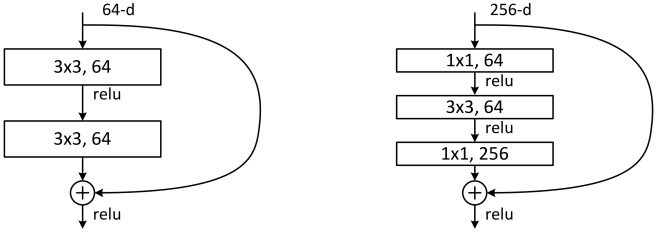

*Both implementations pass on the input forward around the block as a 'skip connection'. This block attempts not to learn directly the correct mapping Hx, but rather the residual function Hx - x. This is an attempt to learn how far the current mapping is from the correct mapping. It can then follow that Fx + x can be the output of these blocks.*

**Basic Block**: (left)
* Assuming the input channels is equal to the output channels, both convolutional layers are of the same (Cin, Cout) so shape doesn't change and you can simply add x to Fx (Fx + x)
* If Cin is not he same as Cout OR the stride isn't 1, then the output Fx is not the same size as x. If this is the case, it is traditional that a downsampling layer is added to x to make x.shape == Fx.shape. This is usually done by a Conv1x1 kernel with Cin, Cout and appropriate stride.

**Bottleneck Block**: (right)
* By projecting the input dimension down into a lower number of channels, you can get away with deeper models with less parameters.
* Steps:
  * Reduce data size
  * Process the data in lower dimensions
  * Expand data back up to add the input into it
* Efficiency Gains:
  * Since we are doing the main processing in lower dimensions, and using the efficient 1x1 conv
  * 2. If downsampling is required to match the Cin, Cout, then you get to pass through 3 conv layers first as opposed to the 2 in the basic block.



  **General Notes:**
* Batchnorm centers at 0, so the bias becomes a mute point, no need for an affine function. The Beta term in BN acts as the new bias.


## Resnet Basic Block

In [ ]:
class ResNetBasicBlock(torch.nn.Module):


    def __init__(self, in_channels, out_channels, stride=1):
        super(ResNetBasicBlock, self).__init__()

        # the resnet block has a 3x3 kernel in the basic block
        self.conv1 = torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = torch.nn.BatchNorm2d(out_channels)

        self.relu = torch.nn.ReLU(inplace=True)

        # dont stride here because you want to maintain size
        self.conv2 = torch.nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = torch.nn.BatchNorm2d(out_channels)

        self.downsample = None

        if in_channels != out_channels or stride > 1:
            self.downsample = torch.nn.Sequential(
                torch.nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                torch.nn.BatchNorm2d(out_channels)
            )


    def forward(self, x):
      x_in = x

      Fx = self.conv1(x)
      Fx = self.bn1(Fx)

      Fx = self.relu(Fx)

      Fx = self.conv2(Fx)
      Fx = self.bn2(Fx)

      # if we have a stride > 1 in the first conv layer, we need to downsample
      # the input to have shapes match
      if self.downsample is not None:
        x_in = self.downsample(x)

      # approx the residual function
      Fx = Fx + x_in
      Fx = self.relu(Fx)

      return Fx


## Bottleneck Block

In [ ]:
class ResNetBottleneck(torch.nn.Module):


    def __init__(self, in_channels, reduction_channels, out_channels, stride=1):
        super(ResNetBottleneck, self).__init__()

        # basic idea: reduce to inchannels to redunction channels, the back up to outchannels afterwards

        self.conv1x1_reduction = torch.nn.Conv2d(in_channels, reduction_channels, kernel_size=1, bias=False)
        self.bn1 = torch.nn.BatchNorm2d(reduction_channels)

        self.relu = torch.nn.ReLU(inplace=True)

        self.conv3x3_process = torch.nn.Conv2d(reduction_channels, reduction_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.bn2 = torch.nn.BatchNorm2d(reduction_channels)

        self.conv1x1_expansion = torch.nn.Conv2d(reduction_channels, out_channels, kernel_size=1, bias=False)
        self.bn3 = torch.nn.BatchNorm2d(out_channels)

        self.downsample = None

        if in_channels != out_channels or stride > 1:
            self.downsample = torch.nn.Sequential(
                torch.nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                torch.nn.BatchNorm2d(out_channels)
            )


    def forward(self, x):
      x_in = x

      Fx = self.conv1x1_reduction(x)
      Fx = self.bn1(Fx)
      Fx = self.relu(Fx)

      Fx = self.conv3x3_process(Fx)
      Fx = self.bn2(Fx)
      Fx = self.relu(Fx)

      Fx = self.conv1x1_expansion(Fx)
      Fx = self.bn3(Fx)

      # if we have a stride > 1 in the first conv layer, we need to downsample
      # the input to have shapes match
      if self.downsample is not None:
        x_in = self.downsample(x)

      # approx the residual function
      Fx = Fx + x_in
      Fx = self.relu(Fx)

      return Fx

## ConvNext Block

In [ ]:
class ConvNeXtBlock(torch.nn.Module):

    def __init__(self, Cin, drop_p, scale):
        super(ConvNextBlock, self).__init__()

        self.depthwise_conv = torch.nn.Conv2d(Cin, Cin, kernel_size=7, padding=3, groups=Cin)


## Stem of Resnet

In [ ]:
class ResNetStem(torch.nn.Module):
    # channels may also be termed as planes within the context of blocks
    def __init__(self, in_channels, out_channels, kernel_size=7, stride=2, padding=3, pool=3, pool_stride=2):
        super(ResNetStem, self).__init__()

        # the stem of a
        self.conv = torch.nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
        self.bn = torch.nn.BatchNorm2d(out_channels)
        self.relu = torch.nn.ReLU(inplace=True)
        self.pool = torch.nn.MaxPool2d(kernel_size=pool, stride=pool_stride, padding=1)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.pool(x)

        return x

# Personal Implementation of ResNet: TresNet (Basic Block & BottleNeck Blocks)

In [ ]:
# del model
torch.cuda.empty_cache()
gc.collect()

class TresNetBasic(torch.nn.Module):

    # resnet uses either bottleneck or basic blocks

    def __init__(self, blocks, num_classes=7001):
        super(TresNetBasic, self).__init__()

        layers = []
        self.stem = ResNetStem(in_channels=3, out_channels=blocks[0])
        layers.append(self.stem)

        for i in range(len(blocks) - 1):
            layers.append(ResNetBasicBlock(in_channels=blocks[i], out_channels=blocks[i+1]))



        self.avgpool = torch.nn.AdaptiveAvgPool2d(1)
        layers.append(self.avgpool)

        layers.append(torch.nn.Flatten())

        self.fc = torch.nn.Linear(blocks[-1], num_classes)
        self.features = torch.nn.Sequential(*layers)

    def forward(self, x, return_feats=False):

        feat = self.features(x)

        x = self.fc(feat)

        if return_feats:
            return feat
        else:
            return x


# Initialize your model
# model = TresNetBasic(config['block-channels']).to(DEVICE)
# summary(model, (3, 224, 224))

In [ ]:
# del model
torch.cuda.empty_cache()
gc.collect()

class TresNetBottleneck(torch.nn.Module):

    # resnet uses either bottleneck or basic blocks

    def __init__(self, blocks, reduction_factor, num_classes=7001):
        super(TresNetBottleneck, self).__init__()

        layers = []
        stem = ResNetStem(in_channels=3, out_channels=blocks[0]//reduction_factor)
        layers.append(stem)

        for i in range(len(blocks)):


            prev_ch = blocks[0] // reduction_factor if i == 0 else blocks[i-1]
            curr_ch = blocks[i]
            next_ch = blocks[i] if i == len(blocks)-1 else blocks[i+1]

            if curr_ch != prev_ch:

              stride = 1 if curr_ch > 256 else 2
              layers.append(ResNetBottleneck(in_channels=prev_ch, reduction_channels=(curr_ch // reduction_factor), out_channels=curr_ch, stride=stride))

            elif curr_ch != next_ch:
              layers.append(ResNetBottleneck(in_channels=curr_ch, reduction_channels=(curr_ch // reduction_factor), out_channels=curr_ch))

            else:
              layers.append(ResNetBottleneck(in_channels=curr_ch, reduction_channels=(curr_ch // reduction_factor), out_channels=next_ch))


        avgpool = torch.nn.AdaptiveAvgPool2d(1)
        layers.append(avgpool)


        layers.append(torch.nn.Flatten())

        self.fc = torch.nn.Linear(blocks[-1], num_classes)
        self.features = torch.nn.Sequential(*layers)

    def forward(self, x, return_feats=False):

        feat = self.features(x)

        x = self.fc(feat)

        if return_feats:
            return feat
        else:
            return x


# Initialize your model
model = TresNetBottleneck(config['block-channels'], config['bottleneck-reduction']).to(DEVICE)
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
        ResNetStem-5           [-1, 64, 56, 56]               0
            Conv2d-6           [-1, 64, 56, 56]           4,096
       BatchNorm2d-7           [-1, 64, 56, 56]             128
              ReLU-8           [-1, 64, 56, 56]               0
            Conv2d-9           [-1, 64, 28, 28]          36,864
      BatchNorm2d-10           [-1, 64, 28, 28]             128
             ReLU-11           [-1, 64, 28, 28]               0
           Conv2d-12          [-1, 256, 28, 28]          16,384
      BatchNorm2d-13          [-1, 256, 28, 28]             512
           Conv2d-14          [-1, 256,

In [ ]:
class TresNextBlock(torch.nn.Module):

    # resnet uses either bottleneck or basic blocks

    def __init__(self, blocks, reduction_factor, num_classes=7001):
        super(TresNetBasic, self).__init__()

        layers = []
        self.stem = ResNetStem(in_channels=3, out_channels=blocks[0])
        layers.append(self.stem)

        for i in range(len(blocks) - 1):
            layers.append(ResNetBottleneck(in_channels=blocks[i], reduction_channels=(blocks[i] // reduction_factor), out_channels=blocks[i+1]))

        self.avgpool = torch.nn.AdaptiveAvgPool2d(1)
        layers.append(self.avgpool)

        layers.append(torch.nn.Flatten())

        self.fc = torch.nn.Linear(blocks[-1], num_classes)
        self.features = torch.nn.Sequential(*layers)

    def forward(self, x, return_feats=False):

        feat = self.features(x)

        x = self.fc(feat)

        if return_feats:
            return feat
        else:
            return x

# Loss, Optimizer, and Scheduler Definition

In [ ]:
# --------------------------------------------------- #

# Defining Loss function
criterion = torch.nn.CrossEntropyLoss(label_smoothing=config['label-smoothing']) # TODO: What loss do you need for a multi class classification problem and would label smoothing be beneficial here?

# --------------------------------------------------- #

# Defining Optimizer
optimizer = torch.optim.AdamW(model.parameters(),
                            lr=config['lr']) # TODO: Feel free to pick a different optimizer

# --------------------------------------------------- #

# Defining Scheduler
# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 10, 15, 22], gamma=0.1) # TODO: Use a good scheduler such as ReduceLRonPlateau, StepLR, MultistepLR, CosineAnnealing, etc.
schedulerCA = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, config['epochs'] - config['warmstart'])# TODO: Use a good scheduler such as ReduceLRonPlateau, StepLR, MultistepLR, CosineAnnealing, etc.
schedulerL = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1e-9, total_iters=config['warmstart'])# TODO: Use a good scheduler such as ReduceLRonPlateau, StepLR, MultistepLR, CosineAnnealing, etc.

# --------------------------------------------------- #

# Initialising mixed-precision training. # Good news. We've already implemented FP16 (Mixed precision training) for you
# It is useful only in the case of compatible GPUs such as T4/V100
scaler = torch.cuda.amp.GradScaler()

# Training and Validation Functions

## Classification Task

In [ ]:
def train(model, dataloader, optimizer, criterion):

    model.train()

    # Progress Bar
    batch_bar   = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc='Train', ncols=5)

    num_correct = 0
    total_loss  = 0

    for i, (images, labels) in enumerate(dataloader):

        optimizer.zero_grad() # Zero gradients

        images, labels = images.to(DEVICE), labels.to(DEVICE)

        with torch.cuda.amp.autocast(): # This implements mixed precision. Thats it!
            outputs = model(images)
            loss    = criterion(outputs, labels)

        # Update no. of correct predictions & loss as we iterate
        num_correct     += int((torch.argmax(outputs, axis=1) == labels).sum())
        total_loss      += float(loss.item())

        # tqdm lets you add some details so you can monitor training as you train.
        batch_bar.set_postfix(
            acc         = "{:.04f}%".format(100 * num_correct / (config['batch_size']*(i + 1))),
            loss        = "{:.04f}".format(float(total_loss / (i + 1))),
            num_correct = num_correct,
            lr          = "{:.04f}".format(float(optimizer.param_groups[0]['lr']))
        )

        scaler.scale(loss).backward() # This is a replacement for loss.backward()
        scaler.step(optimizer) # This is a replacement for optimizer.step()
        scaler.update()

        # TODO? Depending on your choice of scheduler,
        # You may want to call some schdulers inside the train function. What are these?

        batch_bar.update() # Update tqdm bar

    batch_bar.close() # You need this to close the tqdm bar

    acc         = 100 * num_correct / (config['batch_size']* len(dataloader))
    total_loss  = float(total_loss / len(dataloader))

    return acc, total_loss

In [ ]:
def validate(model, dataloader, criterion):

    model.eval()
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc='Val', ncols=5)

    num_correct = 0.0
    total_loss = 0.0

    for i, (images, labels) in enumerate(dataloader):

        # Move images to device
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        # Get model outputs
        with torch.inference_mode():
            outputs = model(images)
            loss = criterion(outputs, labels)

        num_correct += int((torch.argmax(outputs, axis=1) == labels).sum())
        total_loss += float(loss.item())

        batch_bar.set_postfix(
            acc="{:.04f}%".format(100 * num_correct / (config['batch_size']*(i + 1))),
            loss="{:.04f}".format(float(total_loss / (i + 1))),
            num_correct=num_correct)

        batch_bar.update()

    batch_bar.close()
    acc = 100 * num_correct / (config['batch_size']* len(dataloader))
    total_loss = float(total_loss / len(dataloader))
    return acc, total_loss

In [ ]:
gc.collect() # These commands help you when you face CUDA OOM error
torch.cuda.empty_cache()

## Verification Task

The verification task consists of the following generalized scenario:
- You are given X unknown identitites
- You are given Y known identitites
- Your goal is to match X unknown identities to Y known identities.

We have given you a verification dataset, that consists of 960 known identities, and 1080 unknown identities. The 1080 unknown identities are split into dev (360) and test (720). Your goal is to compare the unknown identities to the 1080 known identities and assign an identity to each image from the set of unknown identities. Some unknown identities do not have correspondence in known identities, you also need to identify these and label them with a special label n000000.

Your will use/finetune your model trained for classification to compare images between known and unknown identities using a similarity metric and assign labels to the unknown identities.

This will judge your model's performance in terms of the quality of embeddings/features it generates on images/faces it has never seen during training for classification.

In [ ]:
# This obtains the list of known identities from the known folder
known_regex = "/content/data/11-785-s24-hw2p2-verification/known/*/*"
known_paths = [i.split('/')[-2] for i in sorted(glob.glob(known_regex))]

# Obtain a list of images from unknown folders
unknown_dev_regex = "/content/data/11-785-s24-hw2p2-verification/unknown_dev/*"
unknown_test_regex = "/content/data/11-785-s24-hw2p2-verification/unknown_test/*"

# We load the images from known and unknown folders
unknown_dev_images = [Image.open(p) for p in tqdm(sorted(glob.glob(unknown_dev_regex)))]
unknown_test_images = [Image.open(p) for p in tqdm(sorted(glob.glob(unknown_test_regex)))]
known_images = [Image.open(p) for p in tqdm(sorted(glob.glob(known_regex)))]

# Why do you need only ToTensor() here?
# transforms = torchvision.transforms.Compose([
#     torchvision.transforms.ToTensor()])

# try reusing old transforms
transforms = valid_transforms

unknown_dev_images = torch.stack([transforms(x) for x in unknown_dev_images])
unknown_test_images = torch.stack([transforms(x) for x in unknown_test_images])
known_images  = torch.stack([transforms(y) for y in known_images ])
#Print your shapes here to understand what we have done

# You can use other similarity metrics like Euclidean Distance if you wish
similarity_metric = torch.nn.CosineSimilarity(dim= 1, eps= 1e-6)

100%|██████████| 960/960 [00:00<00:00, 14041.32it/s]


In [ ]:
def eval_verification(unknown_images, known_images, model, similarity, batch_size= config['batch_size'], mode='val'):

    unknown_feats, known_feats = [], []

    batch_bar = tqdm(total=len(unknown_images)//batch_size, dynamic_ncols=True, position=0, leave=False, desc=mode)
    model.eval()

    # We load the images as batches for memory optimization and avoiding CUDA OOM errors
    for i in range(0, unknown_images.shape[0], batch_size):
        unknown_batch = unknown_images[i:i+batch_size] # Slice a given portion upto batch_size

        with torch.no_grad():
            unknown_feat = model(unknown_batch.float().to(DEVICE), return_feats=True) #Get features from model
        unknown_feats.append(unknown_feat)
        batch_bar.update()

    batch_bar.close()

    batch_bar = tqdm(total=len(known_images)//batch_size, dynamic_ncols=True, position=0, leave=False, desc=mode)

    for i in range(0, known_images.shape[0], batch_size):
        known_batch = known_images[i:i+batch_size]
        with torch.no_grad():
              known_feat = model(known_batch.float().to(DEVICE), return_feats=True)

        known_feats.append(known_feat)
        batch_bar.update()

    batch_bar.close()

    # Concatenate all the batches
    unknown_feats = torch.cat(unknown_feats, dim=0)
    known_feats = torch.cat(known_feats, dim=0)

    similarity_values = torch.stack([similarity(unknown_feats, known_feature) for known_feature in known_feats])
    # Print the inner list comprehension in a separate cell - what is really happening?

    max_similarity_values, predictions = similarity_values.max(0) #Why are we doing an max here, where are the return values?
    max_similarity_values, predictions = max_similarity_values.cpu().numpy(), predictions.cpu().numpy()


    # Note that in unknown identities, there are identities without correspondence in known identities.
    # Therefore, these identities should be not similar to all the known identities, i.e. max similarity will be below a certain
    # threshold compared with those identities with correspondence.

    # In early submission, you can ignore identities without correspondence, simply taking identity with max similarity value
    pred_id_strings = [known_paths[i] for i in predictions] # Map argmax indices to identity strings

    # After early submission, remove the previous line and uncomment the following code

    # threshold = # Choose a proper threshold
    # NO_CORRESPONDENCE_LABEL = 'n000000'
    # pred_id_strings = []
    # for idx, prediction in enumerate(predictions):
    #     if max_similarity_values[idx] < threshold: # why < ? Thank about what is your similarity metric
    #         pred_id_strings.append(NO_CORRESPONDENCE_LABEL)
    #     else:
    #         pred_id_strings.append(known_paths[prediction])

    if mode == 'val':
      true_ids = pd.read_csv('/content/data/11-785-s24-hw2p2-verification/verification_dev.csv')['label'].tolist()
      accuracy = 100 * accuracy_score(pred_id_strings, true_ids)
      #print("Verification Accuracy = {}".format(accuracy))
      return accuracy, pred_id_strings

    elif mode == 'test':
      return pred_id_strings


In [ ]:
gc.collect() # These commands help you when you face CUDA OOM error
torch.cuda.empty_cache()

# Wandb

In [ ]:
wandb.login(key="58cec1d955c8a558ddb5374428c04433fd0455c6") # API Key is in your wandb account, under settings (wandb.ai/settings)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
# Create your wandb run
run = wandb.init(
    name = config['model'], ## Wandb creates random run names if you skip this field
    reinit = True, ### Allows reinitalizing runs when you re-run this cell
    # run_id = ### Insert specific run id here if you want to resume a previous run
    # resume = "must" ### You need this to resume previous runs, but comment out reinit = True when using this
    project = "hw2p2-ablations", ### Project should be created in your wandb account
    config = config ### Wandb Config for your run
)

wandb: Currently logged in as: atrela (atrela-cmu). Use `wandb login --relogin` to force relogin


# Experiments

In [ ]:
best_class_acc      = 83.0
best_ver_acc        = 42.0

SAVE_DIR = "/content/drive/MyDrive/s24-idl/hw2p2/Alec/models"
if not os.path.exists(SAVE_DIR):
    raise Exception("Save dir does not exist")

for epoch in range(config['epochs']):

    # print("\nEpoch {}/{}".format(epoch+1, config['epochs']))

    curr_lr = float(optimizer.param_groups[0]['lr'])

    train_acc, train_loss = train(model, train_loader, optimizer, criterion) # TODO: What function would you want implement here

    print("\nEpoch {}/{}: \nTrain Acc (Classification) {:.04f}%\t Train Loss (Classification) {:.04f}\t Learning Rate {:.04f}".format(
        epoch + 1, config['epochs'], train_acc, train_loss, curr_lr))

    val_acc, val_loss = validate(model, valid_loader, criterion) # TODO: What function would you want implement here
    print("Val Acc (Classification) {:.04f}%\t Val Loss (Classification) {:.04f}".format(val_acc, val_loss))

    ver_acc, pred_id_strings = eval_verification(unknown_dev_images, known_images,
                                                 model, similarity_metric, config['batch_size'], mode='val')

    print("Val Acc (Verification) {:.04f}%\t ".format(ver_acc))

    wandb.log({"train_classification_acc": train_acc,
               "train_classification_loss":train_loss,
               "val_classification_acc": val_acc,
               "val_classification_loss": val_loss,
               "val_verification_acc": ver_acc,
               "learning_rate": curr_lr})

    # If you are using a scheduler in your train function within your iteration loop,
    # How will you step your scheduler ?
    if epoch < config['warmstart']:
      schedulerL.step()
    else:
      schedulerCA.step()

    if val_acc >= best_class_acc:
        best_valid_acc = val_acc
        torch.save({'model_state_dict':model.state_dict(),
                    'optimizer_state_dict':optimizer.state_dict(),
                    # 'scheduler_state_dict':scheduler.state_dict(),
                    'val_acc': val_acc,
                    'epoch': epoch}, f'{SAVE_DIR}/{config["model"]}_checkpoint_classification.pth')
        wandb.save('checkpoint_verification.pth')
        print("Saved best classification model")

    if ver_acc >= best_ver_acc:
      best_ver_acc = ver_acc
      torch.save({'model_state_dict':model.state_dict(),
                  'optimizer_state_dict':optimizer.state_dict(),
                  # 'scheduler_state_dict':scheduler.state_dict(),
                  'val_acc': ver_acc,
                  'epoch': epoch}, f'{SAVE_DIR}/{config["model"]}_checkpoint_verification.pth')
      wandb.save('checkpoint_verification.pth')
      print("Saved verification model")

# del model
# gc.collect()
# torch.cuda.empty_cache()
### Finish your wandb run
run.finish()


Epoch 1/100: 
Train Acc (Classification) 0.0157%	 Train Loss (Classification) 9.2691	 Learning Rate 0.0027


Val Acc (Classification) 0.0257%	 Val Loss (Classification) 9.1928


Val Acc (Verification) 0.0000%	 



Epoch 2/100: 
Train Acc (Classification) 0.0164%	 Train Loss (Classification) 9.2697	 Learning Rate 0.0040


Val Acc (Classification) 0.0171%	 Val Loss (Classification) 9.1978


Val Acc (Verification) 0.0000%	 



Epoch 3/100: 
Train Acc (Classification) 0.0193%	 Train Loss (Classification) 9.2695	 Learning Rate 0.0053


Val Acc (Classification) 0.0143%	 Val Loss (Classification) 9.1919


Val Acc (Verification) 0.0000%	 



Epoch 4/100: 
Train Acc (Classification) 0.0207%	 Train Loss (Classification) 9.2697	 Learning Rate 0.0067


Val Acc (Classification) 0.0143%	 Val Loss (Classification) 9.1990


Val Acc (Verification) 0.0000%	 



Epoch 5/100: 
Train Acc (Classification) 0.0150%	 Train Loss (Classification) 9.2695	 Learning Rate 0.0080


Val Acc (Classification) 0.0143%	 Val Loss (Classification) 9.1911


Val Acc (Verification) 0.0000%	 



Epoch 6/100: 
Train Acc (Classification) 0.0136%	 Train Loss (Classification) 9.2694	 Learning Rate 0.0093


Val Acc (Classification) 0.0228%	 Val Loss (Classification) 9.1986


Val Acc (Verification) 0.0000%	 



Epoch 7/100: 
Train Acc (Classification) 0.0193%	 Train Loss (Classification) 9.2695	 Learning Rate 0.0107


Val Acc (Classification) 0.0171%	 Val Loss (Classification) 9.2042


Val Acc (Verification) 0.0000%	 



Epoch 8/100: 
Train Acc (Classification) 0.0157%	 Train Loss (Classification) 9.2695	 Learning Rate 0.0120


Val Acc (Classification) 0.0171%	 Val Loss (Classification) 9.1962


Val Acc (Verification) 0.0000%	 



Epoch 9/100: 
Train Acc (Classification) 0.0179%	 Train Loss (Classification) 9.2690	 Learning Rate 0.0133


Val Acc (Classification) 0.0285%	 Val Loss (Classification) 9.1983


Val Acc (Verification) 0.2778%	 



Epoch 10/100: 
Train Acc (Classification) 0.0136%	 Train Loss (Classification) 9.2696	 Learning Rate 0.0147


Val Acc (Classification) 0.0200%	 Val Loss (Classification) 9.2020


Val Acc (Verification) 0.0000%	 



Epoch 11/100: 
Train Acc (Classification) 0.0150%	 Train Loss (Classification) 9.2689	 Learning Rate 0.0160


Val Acc (Classification) 0.0200%	 Val Loss (Classification) 9.2066


Val Acc (Verification) 0.0000%	 



Epoch 12/100: 
Train Acc (Classification) 0.0150%	 Train Loss (Classification) 9.2691	 Learning Rate 0.0173


Val Acc (Classification) 0.0171%	 Val Loss (Classification) 9.1911


Val Acc (Verification) 0.5556%	 



Epoch 13/100: 
Train Acc (Classification) 0.0150%	 Train Loss (Classification) 9.2692	 Learning Rate 0.0187


Val Acc (Classification) 0.0228%	 Val Loss (Classification) 9.2032


Val Acc (Verification) 0.0000%	 



Epoch 14/100: 
Train Acc (Classification) 0.0186%	 Train Loss (Classification) 9.2692	 Learning Rate 0.0200


Val Acc (Classification) 0.0143%	 Val Loss (Classification) 9.2017


Val Acc (Verification) 0.2778%	 



Epoch 15/100: 
Train Acc (Classification) 0.0136%	 Train Loss (Classification) 9.2694	 Learning Rate 0.0200


Val Acc (Classification) 0.0228%	 Val Loss (Classification) 9.2016


Val Acc (Verification) 0.0000%	 



Epoch 16/100: 
Train Acc (Classification) 0.0200%	 Train Loss (Classification) 9.2697	 Learning Rate 0.0200


Val Acc (Classification) 0.0171%	 Val Loss (Classification) 9.1931


Val Acc (Verification) 0.2778%	 



Epoch 17/100: 
Train Acc (Classification) 0.0229%	 Train Loss (Classification) 9.2695	 Learning Rate 0.0200


Val Acc (Classification) 0.0143%	 Val Loss (Classification) 9.1992


Val Acc (Verification) 0.0000%	 



Epoch 18/100: 
Train Acc (Classification) 0.0179%	 Train Loss (Classification) 9.2687	 Learning Rate 0.0200


Val Acc (Classification) 0.0228%	 Val Loss (Classification) 9.1907


Val Acc (Verification) 0.0000%	 



Epoch 19/100: 
Train Acc (Classification) 0.0150%	 Train Loss (Classification) 9.2695	 Learning Rate 0.0199


Val Acc (Classification) 0.0228%	 Val Loss (Classification) 9.2056


Val Acc (Verification) 0.2778%	 



Epoch 20/100: 
Train Acc (Classification) 0.0179%	 Train Loss (Classification) 9.2693	 Learning Rate 0.0199


Val Acc (Classification) 0.0114%	 Val Loss (Classification) 9.2033


Val Acc (Verification) 0.0000%	 



Epoch 21/100: 
Train Acc (Classification) 0.0157%	 Train Loss (Classification) 9.2694	 Learning Rate 0.0198


Val Acc (Classification) 0.0143%	 Val Loss (Classification) 9.1966


Val Acc (Verification) 0.0000%	 



Epoch 22/100: 
Train Acc (Classification) 0.0193%	 Train Loss (Classification) 9.2690	 Learning Rate 0.0198


Val Acc (Classification) 0.0200%	 Val Loss (Classification) 9.1964


Val Acc (Verification) 0.2778%	 



Epoch 23/100: 
Train Acc (Classification) 0.0150%	 Train Loss (Classification) 9.2694	 Learning Rate 0.0197


Val Acc (Classification) 0.0228%	 Val Loss (Classification) 9.2041


Val Acc (Verification) 0.0000%	 



Epoch 24/100: 
Train Acc (Classification) 0.0193%	 Train Loss (Classification) 9.2695	 Learning Rate 0.0196


Val Acc (Classification) 0.0143%	 Val Loss (Classification) 9.1979


Val Acc (Verification) 0.2778%	 



Epoch 25/100: 
Train Acc (Classification) 0.0114%	 Train Loss (Classification) 9.2692	 Learning Rate 0.0195


Val Acc (Classification) 0.0200%	 Val Loss (Classification) 9.1991


Val Acc (Verification) 0.0000%	 



Epoch 26/100: 
Train Acc (Classification) 0.0179%	 Train Loss (Classification) 9.2692	 Learning Rate 0.0193


Val Acc (Classification) 0.0171%	 Val Loss (Classification) 9.1945


Val Acc (Verification) 0.2778%	 



Epoch 27/100: 
Train Acc (Classification) 0.0129%	 Train Loss (Classification) 9.2694	 Learning Rate 0.0192


Val Acc (Classification) 0.0143%	 Val Loss (Classification) 9.2036


Val Acc (Verification) 0.0000%	 



Epoch 28/100: 
Train Acc (Classification) 0.0143%	 Train Loss (Classification) 9.2693	 Learning Rate 0.0190


Val Acc (Classification) 0.0114%	 Val Loss (Classification) 9.1926


Val Acc (Verification) 0.0000%	 



Epoch 29/100: 
Train Acc (Classification) 0.0164%	 Train Loss (Classification) 9.2692	 Learning Rate 0.0189


Val Acc (Classification) 0.0171%	 Val Loss (Classification) 9.1991


Val Acc (Verification) 0.0000%	 



Epoch 30/100: 
Train Acc (Classification) 0.0200%	 Train Loss (Classification) 9.2695	 Learning Rate 0.0187


Val Acc (Classification) 0.0171%	 Val Loss (Classification) 9.2006


Val Acc (Verification) 0.0000%	 



Epoch 31/100: 
Train Acc (Classification) 0.0129%	 Train Loss (Classification) 9.2695	 Learning Rate 0.0185


Val Acc (Classification) 0.0143%	 Val Loss (Classification) 9.1948


Val Acc (Verification) 0.2778%	 



Epoch 32/100: 
Train Acc (Classification) 0.0136%	 Train Loss (Classification) 9.2690	 Learning Rate 0.0183


Val Acc (Classification) 0.0114%	 Val Loss (Classification) 9.1969


Val Acc (Verification) 0.2778%	 



Epoch 33/100: 
Train Acc (Classification) 0.0171%	 Train Loss (Classification) 9.2694	 Learning Rate 0.0181


Val Acc (Classification) 0.0342%	 Val Loss (Classification) 9.1904


Val Acc (Verification) 0.0000%	 



Epoch 34/100: 
Train Acc (Classification) 0.0179%	 Train Loss (Classification) 9.2691	 Learning Rate 0.0179


Val Acc (Classification) 0.0200%	 Val Loss (Classification) 9.2014


Val Acc (Verification) 0.0000%	 



Epoch 35/100: 
Train Acc (Classification) 0.0164%	 Train Loss (Classification) 9.2695	 Learning Rate 0.0176


Val Acc (Classification) 0.0200%	 Val Loss (Classification) 9.1970


Val Acc (Verification) 0.2778%	 



Epoch 36/100: 
Train Acc (Classification) 0.0164%	 Train Loss (Classification) 9.2693	 Learning Rate 0.0174


Val Acc (Classification) 0.0171%	 Val Loss (Classification) 9.1965


Val Acc (Verification) 0.0000%	 



Epoch 37/100: 
Train Acc (Classification) 0.0157%	 Train Loss (Classification) 9.2691	 Learning Rate 0.0171


Val Acc (Classification) 0.0200%	 Val Loss (Classification) 9.2012


Val Acc (Verification) 0.2778%	 



Epoch 38/100: 
Train Acc (Classification) 0.0171%	 Train Loss (Classification) 9.2695	 Learning Rate 0.0169


Val Acc (Classification) 0.0285%	 Val Loss (Classification) 9.1926


Val Acc (Verification) 0.0000%	 



Epoch 39/100: 
Train Acc (Classification) 0.0143%	 Train Loss (Classification) 9.2695	 Learning Rate 0.0166


Val Acc (Classification) 0.0200%	 Val Loss (Classification) 9.1956


Val Acc (Verification) 0.2778%	 



Epoch 40/100: 
Train Acc (Classification) 0.0200%	 Train Loss (Classification) 9.2693	 Learning Rate 0.0163


Val Acc (Classification) 0.0200%	 Val Loss (Classification) 9.2000


Val Acc (Verification) 0.0000%	 



Epoch 41/100: 
Train Acc (Classification) 0.0171%	 Train Loss (Classification) 9.2695	 Learning Rate 0.0160


Val Acc (Classification) 0.0171%	 Val Loss (Classification) 9.1988


Val Acc (Verification) 0.0000%	 



Epoch 42/100: 
Train Acc (Classification) 0.0136%	 Train Loss (Classification) 9.2695	 Learning Rate 0.0157


Val Acc (Classification) 0.0086%	 Val Loss (Classification) 9.2009


Val Acc (Verification) 0.2778%	 



Epoch 43/100: 
Train Acc (Classification) 0.0136%	 Train Loss (Classification) 9.2695	 Learning Rate 0.0154


Val Acc (Classification) 0.0200%	 Val Loss (Classification) 9.1963


Val Acc (Verification) 0.0000%	 



Epoch 44/100: 
Train Acc (Classification) 0.0129%	 Train Loss (Classification) 9.2691	 Learning Rate 0.0151


Val Acc (Classification) 0.0171%	 Val Loss (Classification) 9.2017


Val Acc (Verification) 0.0000%	 



Epoch 45/100: 
Train Acc (Classification) 0.0150%	 Train Loss (Classification) 9.2692	 Learning Rate 0.0148


Val Acc (Classification) 0.0143%	 Val Loss (Classification) 9.2013


Val Acc (Verification) 0.0000%	 



Epoch 46/100: 
Train Acc (Classification) 0.0129%	 Train Loss (Classification) 9.2692	 Learning Rate 0.0145


Val Acc (Classification) 0.0200%	 Val Loss (Classification) 9.2023


Val Acc (Verification) 0.0000%	 



Epoch 47/100: 
Train Acc (Classification) 0.0114%	 Train Loss (Classification) 9.2696	 Learning Rate 0.0141


Val Acc (Classification) 0.0342%	 Val Loss (Classification) 9.1941


Val Acc (Verification) 0.2778%	 



Epoch 48/100: 
Train Acc (Classification) 0.0186%	 Train Loss (Classification) 9.2695	 Learning Rate 0.0138


Val Acc (Classification) 0.0143%	 Val Loss (Classification) 9.2062


Val Acc (Verification) 0.0000%	 



Epoch 49/100: 
Train Acc (Classification) 0.0171%	 Train Loss (Classification) 9.2695	 Learning Rate 0.0134


Val Acc (Classification) 0.0257%	 Val Loss (Classification) 9.1875


Val Acc (Verification) 0.2778%	 



Epoch 50/100: 
Train Acc (Classification) 0.0129%	 Train Loss (Classification) 9.2692	 Learning Rate 0.0131


Val Acc (Classification) 0.0228%	 Val Loss (Classification) 9.2004


Val Acc (Verification) 0.2778%	 



Epoch 51/100: 
Train Acc (Classification) 0.0129%	 Train Loss (Classification) 9.2694	 Learning Rate 0.0127


Val Acc (Classification) 0.0200%	 Val Loss (Classification) 9.2003


Val Acc (Verification) 0.2778%	 



Epoch 52/100: 
Train Acc (Classification) 0.0164%	 Train Loss (Classification) 9.2698	 Learning Rate 0.0124


Val Acc (Classification) 0.0285%	 Val Loss (Classification) 9.1961


Val Acc (Verification) 0.2778%	 



Epoch 53/100: 
Train Acc (Classification) 0.0157%	 Train Loss (Classification) 9.2698	 Learning Rate 0.0120


Val Acc (Classification) 0.0228%	 Val Loss (Classification) 9.1964


Val Acc (Verification) 0.5556%	 



Epoch 54/100: 
Train Acc (Classification) 0.0136%	 Train Loss (Classification) 9.2690	 Learning Rate 0.0117


Val Acc (Classification) 0.0228%	 Val Loss (Classification) 9.1965


Val Acc (Verification) 0.0000%	 



Epoch 55/100: 
Train Acc (Classification) 0.0221%	 Train Loss (Classification) 9.2691	 Learning Rate 0.0113


Val Acc (Classification) 0.0257%	 Val Loss (Classification) 9.1953


Val Acc (Verification) 0.0000%	 



Epoch 56/100: 
Train Acc (Classification) 0.0193%	 Train Loss (Classification) 9.2693	 Learning Rate 0.0109


Val Acc (Classification) 0.0228%	 Val Loss (Classification) 9.1981


Val Acc (Verification) 0.2778%	 



Epoch 57/100: 
Train Acc (Classification) 0.0164%	 Train Loss (Classification) 9.2697	 Learning Rate 0.0106


Val Acc (Classification) 0.0285%	 Val Loss (Classification) 9.1949


Val Acc (Verification) 0.0000%	 



Epoch 58/100: 
Train Acc (Classification) 0.0179%	 Train Loss (Classification) 9.2693	 Learning Rate 0.0102


Val Acc (Classification) 0.0228%	 Val Loss (Classification) 9.1934


Val Acc (Verification) 0.0000%	 



Epoch 59/100: 
Train Acc (Classification) 0.0171%	 Train Loss (Classification) 9.2696	 Learning Rate 0.0098


Val Acc (Classification) 0.0257%	 Val Loss (Classification) 9.1927


Val Acc (Verification) 0.0000%	 



Epoch 60/100: 
Train Acc (Classification) 0.0157%	 Train Loss (Classification) 9.2689	 Learning Rate 0.0095


Val Acc (Classification) 0.0228%	 Val Loss (Classification) 9.1926


Val Acc (Verification) 0.0000%	 



Epoch 61/100: 
Train Acc (Classification) 0.0129%	 Train Loss (Classification) 9.2695	 Learning Rate 0.0091


Val Acc (Classification) 0.0228%	 Val Loss (Classification) 9.1942


Val Acc (Verification) 0.2778%	 



Epoch 62/100: 
Train Acc (Classification) 0.0171%	 Train Loss (Classification) 9.2696	 Learning Rate 0.0087


Val Acc (Classification) 0.0143%	 Val Loss (Classification) 9.1969


Val Acc (Verification) 0.0000%	 



Epoch 63/100: 
Train Acc (Classification) 0.0171%	 Train Loss (Classification) 9.2696	 Learning Rate 0.0084


Val Acc (Classification) 0.0200%	 Val Loss (Classification) 9.2005


Val Acc (Verification) 0.0000%	 



Epoch 64/100: 
Train Acc (Classification) 0.0207%	 Train Loss (Classification) 9.2695	 Learning Rate 0.0080


Val Acc (Classification) 0.0171%	 Val Loss (Classification) 9.1966


Val Acc (Verification) 0.2778%	 



Epoch 65/100: 
Train Acc (Classification) 0.0157%	 Train Loss (Classification) 9.2696	 Learning Rate 0.0076


Val Acc (Classification) 0.0200%	 Val Loss (Classification) 9.1902


Val Acc (Verification) 0.0000%	 



Epoch 66/100: 
Train Acc (Classification) 0.0143%	 Train Loss (Classification) 9.2692	 Learning Rate 0.0073


Val Acc (Classification) 0.0143%	 Val Loss (Classification) 9.2000


Val Acc (Verification) 0.2778%	 



Epoch 67/100: 
Train Acc (Classification) 0.0157%	 Train Loss (Classification) 9.2695	 Learning Rate 0.0069


Val Acc (Classification) 0.0228%	 Val Loss (Classification) 9.1988


Val Acc (Verification) 0.0000%	 



Epoch 68/100: 
Train Acc (Classification) 0.0121%	 Train Loss (Classification) 9.2695	 Learning Rate 0.0066


Val Acc (Classification) 0.0228%	 Val Loss (Classification) 9.1923


Val Acc (Verification) 0.0000%	 



Epoch 69/100: 
Train Acc (Classification) 0.0193%	 Train Loss (Classification) 9.2696	 Learning Rate 0.0062


Val Acc (Classification) 0.0285%	 Val Loss (Classification) 9.1915


Val Acc (Verification) 0.0000%	 



Epoch 70/100: 
Train Acc (Classification) 0.0143%	 Train Loss (Classification) 9.2693	 Learning Rate 0.0059


Val Acc (Classification) 0.0228%	 Val Loss (Classification) 9.1943


Val Acc (Verification) 0.2778%	 



Epoch 71/100: 
Train Acc (Classification) 0.0171%	 Train Loss (Classification) 9.2694	 Learning Rate 0.0055


Val Acc (Classification) 0.0228%	 Val Loss (Classification) 9.2006


Val Acc (Verification) 0.2778%	 



Epoch 72/100: 
Train Acc (Classification) 0.0136%	 Train Loss (Classification) 9.2689	 Learning Rate 0.0052


Val Acc (Classification) 0.0171%	 Val Loss (Classification) 9.1961


Val Acc (Verification) 0.0000%	 



Epoch 73/100: 
Train Acc (Classification) 0.0179%	 Train Loss (Classification) 9.2692	 Learning Rate 0.0049


Val Acc (Classification) 0.0257%	 Val Loss (Classification) 9.2003


Val Acc (Verification) 0.2778%	 



Epoch 74/100: 
Train Acc (Classification) 0.0129%	 Train Loss (Classification) 9.2698	 Learning Rate 0.0046


Val Acc (Classification) 0.0171%	 Val Loss (Classification) 9.1941


Val Acc (Verification) 0.0000%	 



Epoch 75/100: 
Train Acc (Classification) 0.0136%	 Train Loss (Classification) 9.2696	 Learning Rate 0.0043


Val Acc (Classification) 0.0143%	 Val Loss (Classification) 9.2005


Val Acc (Verification) 0.2778%	 



Epoch 76/100: 
Train Acc (Classification) 0.0171%	 Train Loss (Classification) 9.2689	 Learning Rate 0.0040


Val Acc (Classification) 0.0143%	 Val Loss (Classification) 9.1951


Val Acc (Verification) 0.0000%	 



Epoch 77/100: 
Train Acc (Classification) 0.0157%	 Train Loss (Classification) 9.2697	 Learning Rate 0.0037


Val Acc (Classification) 0.0114%	 Val Loss (Classification) 9.1930


Val Acc (Verification) 0.2778%	 



Epoch 78/100: 
Train Acc (Classification) 0.0129%	 Train Loss (Classification) 9.2696	 Learning Rate 0.0034


Val Acc (Classification) 0.0200%	 Val Loss (Classification) 9.2014


Val Acc (Verification) 0.2778%	 



Epoch 79/100: 
Train Acc (Classification) 0.0157%	 Train Loss (Classification) 9.2688	 Learning Rate 0.0031


Val Acc (Classification) 0.0143%	 Val Loss (Classification) 9.1975


Val Acc (Verification) 0.2778%	 


Train:  98%|█████████▊| 1068/1094 [04:26<00:06,  3.97it/s, acc=0.0146%, loss=9.2689, lr=0.0029, num_correct=20]

# Testing and Kaggle Submission

In [ ]:
def test(model,dataloader): # TODO: Run to finish predicting on the test set.

  model.eval()
  batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc='Test')
  test_results = []

  for i, (images) in enumerate(dataloader):

      images = images.to(DEVICE)

      with torch.inference_mode():
        outputs = model(images)

      outputs = torch.argmax(outputs, axis=1).detach().cpu().numpy().tolist()
      test_results.extend(outputs)

      batch_bar.update()

  batch_bar.close()
  return test_results

In [ ]:
test_results = test(model, test_loader)

In [ ]:
pred_id_strings = eval_verification(unknown_test_images, known_images,
                                                 model, similarity_metric, config['batch_size'], mode='test')

In [ ]:
# TODO: Run to write the results in the files and submit to Kaggle
# You only have 10 Kaggle submissions per day

with open(f"{SAVE_DIR}/{config['model']}_submission.csv", "w+") as f:
    f.write("id,label\n")
    for i in range(len(test_dataset)):
        f.write("{},{}\n".format(str(i).zfill(6) + ".jpg", test_results[i]))

with open(f"{SAVE_DIR}/{config['model']}_submission.csv", "w+") as f:
    f.write("id,label\n")
    for i in range(len(pred_id_strings)):
        f.write("{},{}\n".format(i, pred_id_strings[i]))

In [ ]:
SAVE_DIR = "/content/MyDrive/MyDrive/"
with open(f"{SAVE_DIR}/tresnet_classification_early_submission.csv", "w+") as f:
    f.write("id,label\n")
    for i in range(len(test_dataset)):
        f.write("{},{}\n".format(str(i).zfill(6) + ".jpg", test_results[i]))

with open(f"{SAVE_DIR}/tresnet_bot_verification_early_submission.csv", "w+") as f:
    f.write("id,label\n")
    for i in range(len(pred_id_strings)):
        f.write("{},{}\n".format(i, pred_id_strings[i]))

In [ ]:
kaggle competitions submit -c 11785-hw2p2-face-recognition -f submission.csv -m "Early-Submission"
kaggle competitions submit -c 11785-hw2p2-face-verification -f submission.csv -m "Early-Submission"

# Finetune your Model

You can choose any model for finetuning. It is a good practice to try to sweep through all the models to find what is the best finetuning model for you!

## Model Definition (finetuning)

In [ ]:
# add your finetune/retrain code here

## Loss, Optimizer, and Scheduler Definition (finetuning)

In [ ]:
# add your finetune/retrain code here

## Training Function (finetuning)

In [ ]:
# add your finetune/retrain code here

## Wandb (finetuning)

In [ ]:
# add your finetune/retrain code here

## Experiments (finetuning)

In [ ]:
# add your finetune/retrain code here